# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [111]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [112]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

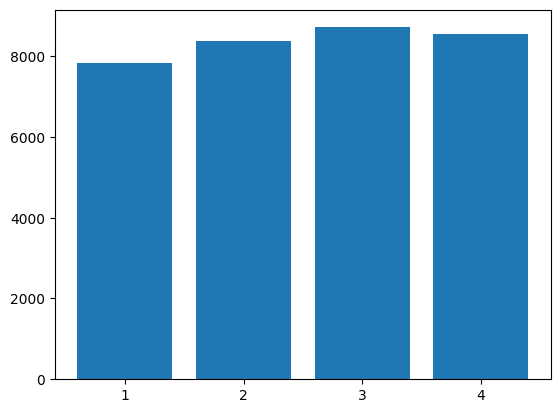

In [113]:
plt.bar(df['season'], df['cnt'])
plt.xticks([1, 2, 3, 4])
plt.show()

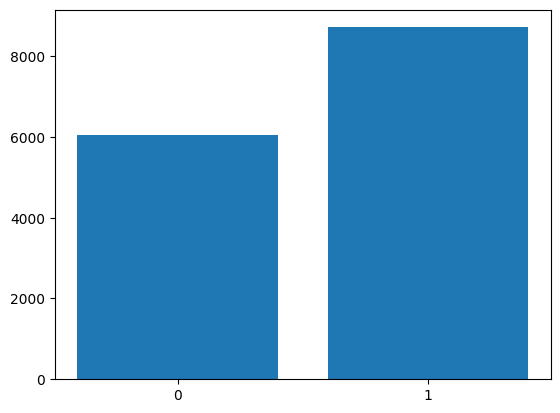

In [114]:
plt.bar(df['yr'], df['cnt'])
plt.xticks([0, 1])
plt.show()

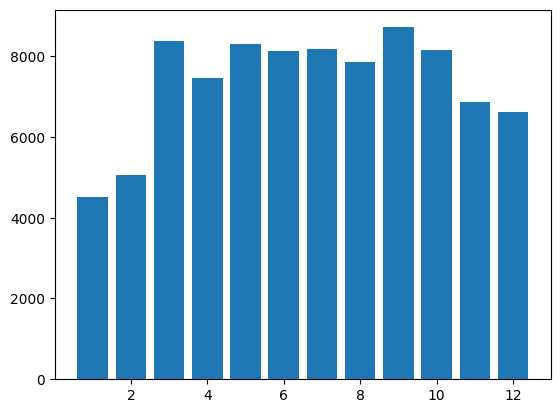

In [115]:
plt.bar(df['mnth'], df['cnt'])
plt.show()

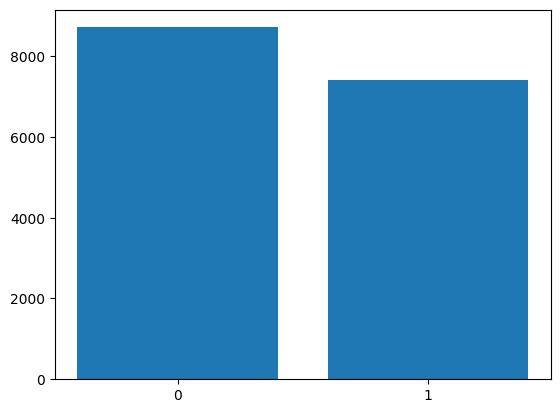

In [116]:
plt.bar(df['holiday'], df['cnt'])
plt.xticks([0, 1])
plt.show()

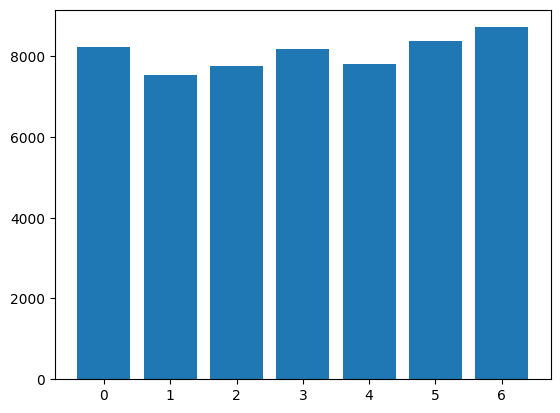

In [117]:
plt.bar(df['weekday'], df['cnt'])
plt.xticks([0, 1, 2 , 3, 4, 5, 6])
plt.show()

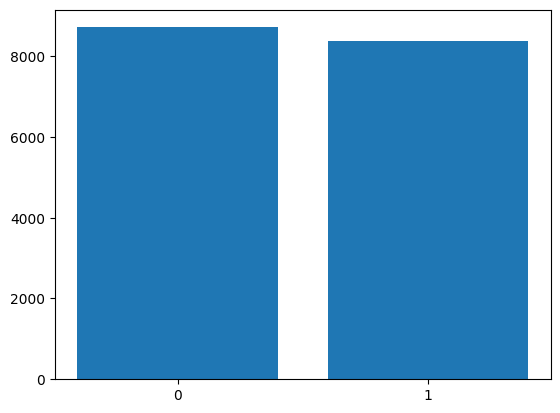

In [118]:
plt.bar(df['workingday'], df['cnt'])
plt.xticks([0, 1])
plt.show()

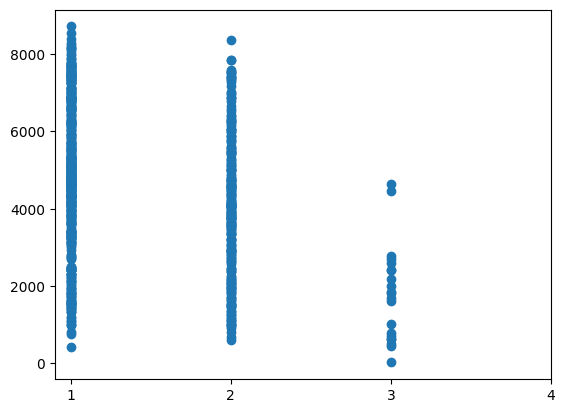

In [119]:
plt.scatter(df['weathersit'], df['cnt'])
plt.xticks([1, 2, 3, 4])
plt.show()

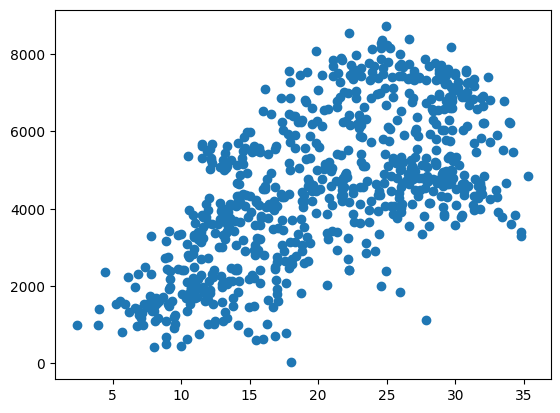

In [120]:
plt.scatter(df['temp'], df['cnt'])
plt.show()

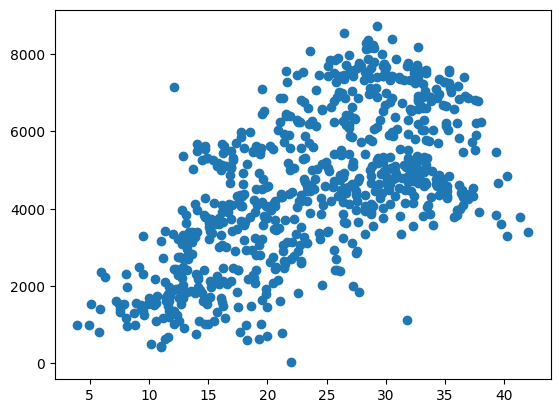

In [121]:
plt.scatter(df['atemp'], df['cnt'])
plt.show()

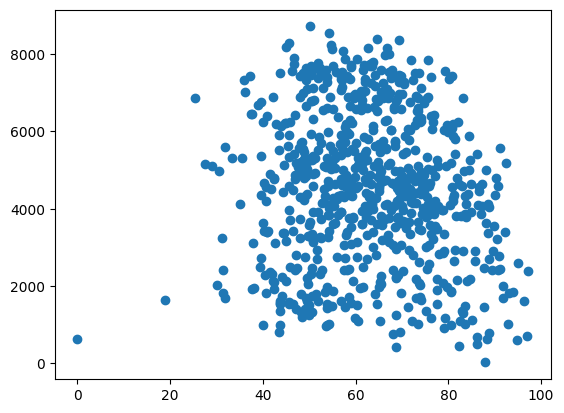

In [122]:
plt.scatter(df['hum'], df['cnt'])
plt.show()

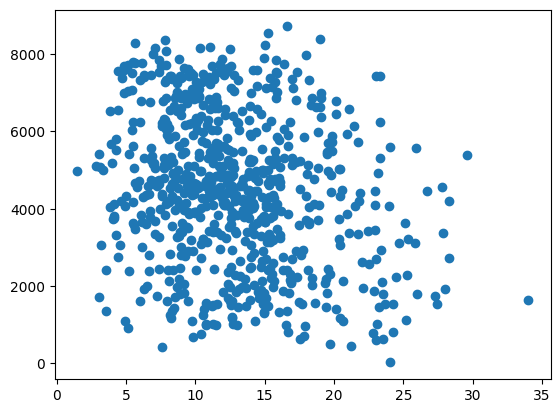

In [123]:
plt.scatter(df['windspeed(mph)'], df['cnt'])
plt.show()

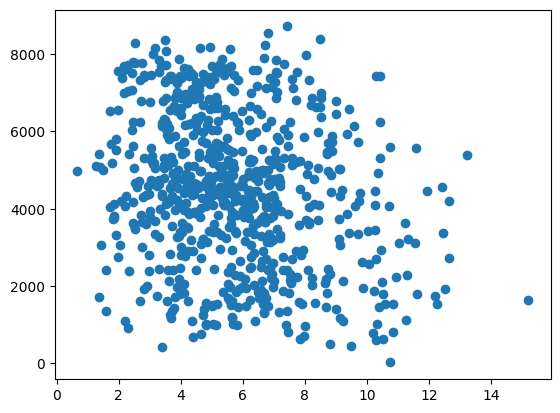

In [124]:
plt.scatter(df['windspeed(ms)'], df['cnt'])
plt.show()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

1 схожий на параболу
2 погодні умови (weathersit), святковий день (holiday), швидкість вітру  


## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [125]:
correlations = df.iloc[:, :-1].corrwith(df['cnt'])
print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [126]:
correlation = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()
print(correlation)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [127]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [128]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [129]:
df_shuffled = shuffle(df, random_state=41)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]
df_shuffled

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
20,1,0,1,0,5,1,1,7.277500,7.89165,45.7083,23.667214,10.579890,1543
410,1,1,2,0,3,1,1,14.281653,17.58145,53.1250,12.167200,5.439070,4169
648,4,1,10,0,3,1,1,21.080847,25.15710,63.0833,12.584007,5.625394,7691
208,3,0,7,0,4,1,1,31.945847,36.99500,58.3333,11.958093,5.345594,4390
678,4,1,11,0,5,1,1,14.828347,17.77065,54.0833,14.375386,6.426190,5992
...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,1,1,2,0,0,0,1,5.227500,5.08290,46.4583,27.417204,12.256238,1529
601,3,1,8,0,5,1,2,28.802500,32.35500,61.5000,4.833769,2.160826,7582
243,3,0,9,0,4,1,1,26.855000,30.74605,63.9167,9.500332,4.246907,5115
321,4,0,11,0,5,1,1,11.240847,13.63605,41.0000,11.291711,5.047703,3392


Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [130]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [131]:
regressor = LinearRegression().fit(X, y)
weights = regressor.coef_

feature_weights = list(zip(df.columns[:-1], weights))

for feature, weight in feature_weights:
    print(f"{feature}: {weight}")

season: 570.8683853379154
yr: 1021.962287848617
mnth: -141.30447395591966
holiday: -86.75702249403247
weekday: 137.22687330665656
workingday: 56.39111331652636
weathersit: -330.2332556629414
temp: 367.4733221941795
atemp: 585.557998488518
hum: -145.6042647847906
windspeed(mph): 12458249604197.072
windspeed(ms): -12458249604395.525


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [132]:
from sklearn.linear_model import Lasso
regr_L1 = Lasso()
regr_L1.fit(X, y)
feature_weights_Lasso = list(zip(df.columns[:-1], regr_L1.coef_))

for feature, weight in feature_weights_Lasso:
    print(f"{feature}: {weight}")
print(f"w0: ", regr_L1.intercept_)

season: 560.2416160308866
yr: 1019.4634940657195
mnth: -128.73062703678724
holiday: -86.15278133371108
weekday: 137.3478939049631
workingday: 55.212370641356806
weathersit: -332.36985696234854
temp: 376.36323620969756
atemp: 576.5307935045521
hum: -144.129155003486
windspeed(mph): -197.1396894024861
windspeed(ms): -2.804937010672013e-08
w0:  4504.3488372093025


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [133]:
from sklearn.linear_model import Ridge
regr_L2 = Ridge()
regr_L2.fit(X, y)
feature_weights_Lasso = list(zip(df.columns[:-1], regr_L2.coef_))

for feature, weight in feature_weights_Lasso:
    print(f"{feature}: {weight}")
print(f"w0: ", regr_L2.intercept_)

season: 563.0645722520161
yr: 1018.9483787875274
mnth: -131.87332028247565
holiday: -86.7460979970923
weekday: 138.00511117871932
workingday: 55.90311037506438
weathersit: -332.3497884990723
temp: 386.4578891918901
atemp: 566.347047060086
hum: -145.07132729867342
windspeed(mph): -99.25944108180359
windspeed(ms): -99.25944115432883
w0:  4504.3488372093025


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [134]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    regr_L1 = Lasso(alpha=alpha)
    regr_L1.fit(X, y)   
    coefs_lasso.append(regr_L1.coef_)

    regr_L2 = Ridge(alpha=alpha)
    regr_L2.fit(X, y)   
    coefs_ridge.append(regr_L2.coef_)    
    
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проанализируйте динамику весов при увеличении параметра регуляризации:

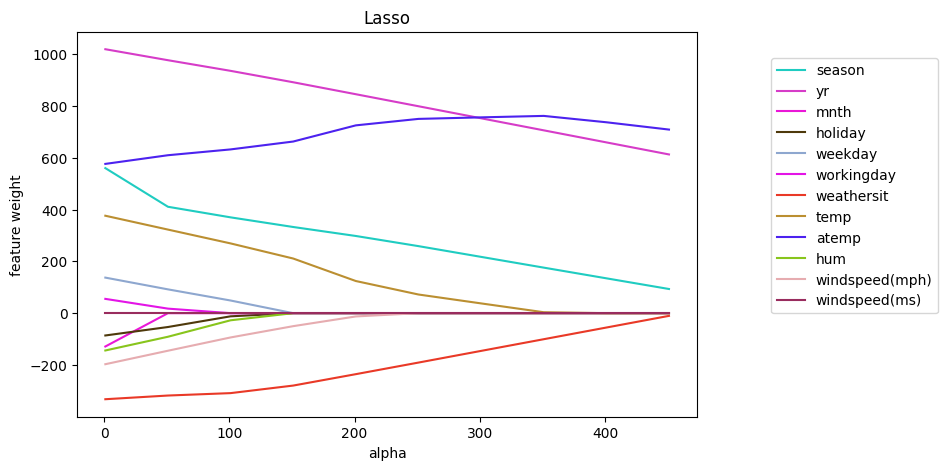

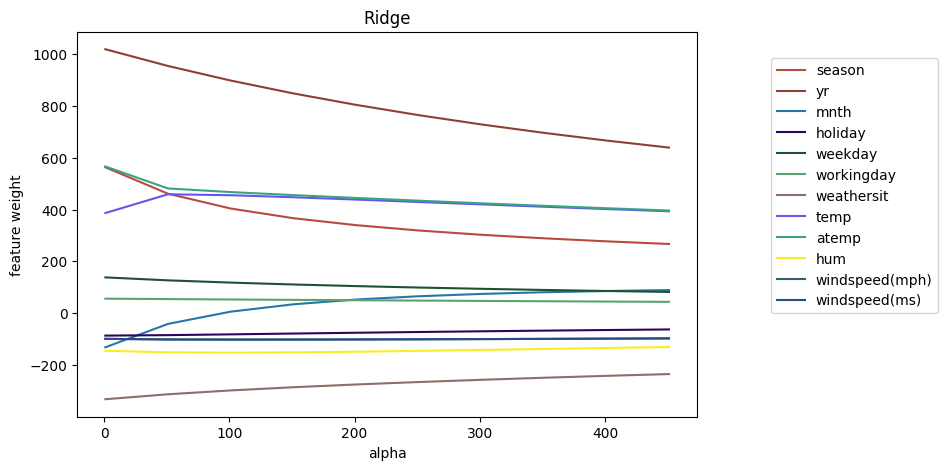

In [135]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

1 Lasso
2 Вони всі дійдуть до 0. Це відбувається так, тому що метод має штраф за великі коефіцієнти моделі
3 Так. windspeed(ms) практично з альфа=0 обнуляється. Ridge не працює таким чином
4 Лассо, бо він автоматично виключає меньш інформативні ознаки при високих значеннях Альфа. акий регуляризатор здійснює відбір ознак і дозволяє використовувати в моделі не всі ознаки, а лише найважливіші з них.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ частей, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [136]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = data["x"]
    y = data["y"]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    x_ticks = np.concatenate((np.arange(0, 11, 2),np.arange(10, 101, 5))) 
    plt.xticks(x_ticks)
    plt.grid()
    plt.show()

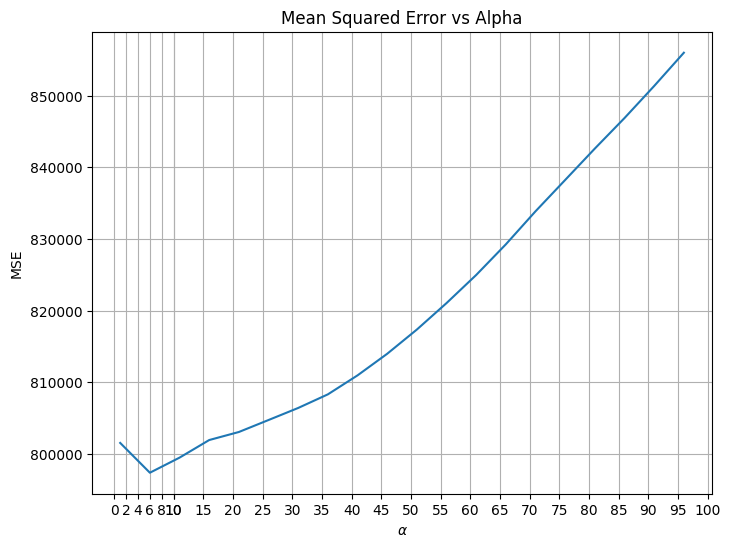

Optimal alpha =  6
Optimal weights:
season: 532.0
yr: 1015.0
mnth: -100.0
holiday: -83.0
weekday: 133.0
workingday: 52.0
weathersit: -331.0
temp: 371.0
atemp: 581.0
hum: -140.0
windspeed(mph): -192.0
windspeed(ms): -0.0


In [137]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

lcv_regressor = LassoCV(alphas = alphas, cv=5)
lcv_regressor.fit(X, y)

mse_mean = pd.DataFrame(lcv_regressor.mse_path_.mean(axis=1))
mse_mean.index = lcv_regressor.alphas_
mse_mean.index.name = 'alpha'
mse_mean.columns = ['Mean_MSE']
mse_mean.sort_index()
plot_data = {"x": mse_mean.index, "y": mse_mean["Mean_MSE"]}
create_plot(
    plot_data, "Mean Squared Error vs Alpha", r"$\alpha$", "MSE", figsize=(8, 6)
)
print("Optimal alpha = ", lcv_regressor.alpha_)
optimal_weights = list(zip(df.columns,lcv_regressor.coef_.round(0)))
print('Optimal weights:')
for feature, weight in optimal_weights:
    print(f"{feature}: {weight}")

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


k_1     1
k_2     1
k_3     1
k_4    86
k_5    36
dtype: int32


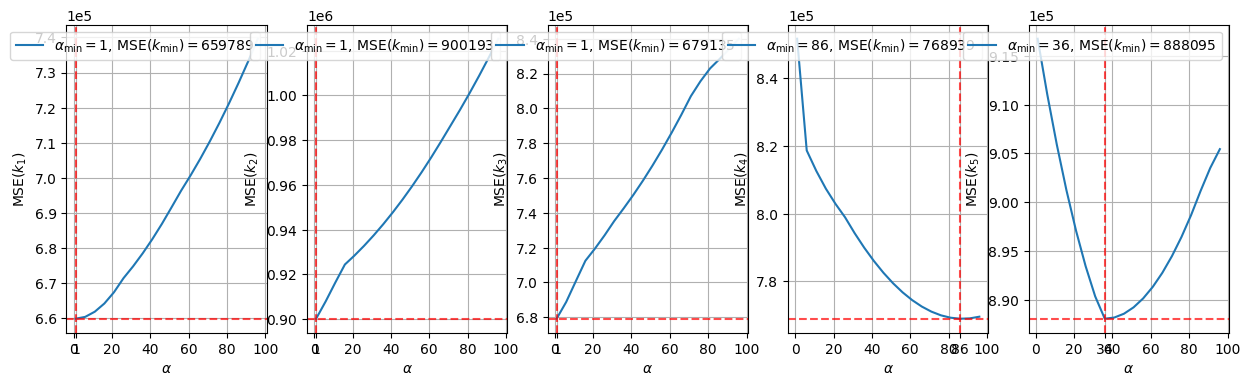

In [138]:
mse = pd.DataFrame(lcv_regressor.mse_path_)
mse.index = lcv_regressor.alphas_
mse.index.name = 'alpha'
mse.columns = ['k_1', 'k_2', 'k_3', 'k_4', 'k_5']

min_alpha_values = mse.idxmin()
print(min_alpha_values)
min_indices = {i: mse.iloc[:, i].idxmin() for i in range(0, 5)}
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for col, min_index in min_indices.items():
    axes[col].plot(
        mse.index,
        mse[f"k_{col+1}"],
        label=r"$\alpha_{{\min}} = {}$, $\mathrm{{MSE}}(k_{{\min}}) = {:.0f}$".format(
            min_index, mse.loc[min_index, f"k_{col+1}"]
        ),
    )
    axes[col].set_xlabel(r"$\alpha$")
    axes[col].set_ylabel(rf"MSE($k_{col+1}$)")
    axes[col].ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
    axes[col].grid(which="both")
    axes[col].legend(loc='upper right')

    main_ticks = np.arange(0, 101, 20)

    tick = min_index
    ytick = mse.loc[min_index, f"k_{col+1}"]

    all_ticks = np.sort(np.concatenate((main_ticks, [tick])))

    axes[col].axvline(x=tick, color='red', linestyle='--', alpha=0.7)
    axes[col].axhline(y=ytick, color='red', linestyle='--', alpha=0.7)

    axes[col].set_xticks(all_ticks)

plt.show()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__

In [139]:
lassoCV_weights = pd.DataFrame(zip(df.columns, lcv_regressor.coef_), columns=['Feature', 'Lasso CV Weight'])
top_4_lassoCV = lassoCV_weights.sort_values(by='Lasso CV Weight', ascending=False).head(4)
top_4_lassoCV['Lasso CV Weight'] = top_4_lassoCV['Lasso CV Weight'].round(1)
top_4_lassoCV.reset_index(drop=True)


,Feature,Lasso CV Weight
0,yr,1015.1
1,atemp,581.4
2,season,532.0
3,temp,370.7


1 так, залежність cnt росте разом з величиною ознак

2 для року не логічно - це співпадіння, для сезону, найбільше беруть восени, тобто це не зовсім лінійна залежнімть. Для температури - залежність лінйна але до температури 30 градусів, тобто є ектремум, і для температур лійна регрессія не підходить у всьому диапазоні (а тільки до 30 градусів)

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [140]:
low_3_lassoCV = lassoCV_weights.sort_values(by='Lasso CV Weight', ascending=True).head(3)
low_3_lassoCV['Lasso CV Weight'] = low_3_lassoCV['Lasso CV Weight'].round(1)
low_3_lassoCV.reset_index(drop=True)

,Feature,Lasso CV Weight
0,weathersit,-330.6
1,windspeed(mph),-191.8
2,hum,-140.0


1 так, спадаюча залежність видна


2 логічно. Несприятливі погдіні умови, вітер, вологість знижують вірогідність оренди велосипедів

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [142]:
lassoCV_weights[abs(lassoCV_weights['Lasso CV Weight']) < 1e-3]

,Feature,Lasso CV Weight
11,windspeed(ms),-2.685700e-08


1 Модель виключила швидкість вітру в м/с бо ця ознака колінеарна з іншою - швидкість вітру в милях на годину.

2 Не вірно. Вплив цієї ознаки такий самий як і windspeed(mph).

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.